# <font color = white > **Stochastic Simulation (5284STSI6Y) | MSc Computational Science at UvA** </font>

# <font color = LightGreen > **Assignment 2: Discrete-Event Simulation** </font>
*By Victor Piaskowski(15132625), Sanjhana Bhusal (14724383), and Lisa Pahladsingh(13846566)*

Link to Github Repository: https://github.com/BiggusVickus/Stochastic_Simulation

## <font color = LightBlue> **Exercise 1** </font>

#### <font color = Grey> ***MATHEMATICAL EXPLANATION*** </font>
Queing theory is applicable to many real-world scenario's. By looking at $\textit{performance measures}$, such as mean waiting time and the mean number of customers in a system, we can derive some characteristics about the system. We will be looking at the mean waiting time of two different types of queing, namely M/M/1 and M/M/c, with a closer look at M/M/2. Hence we will compare queing with one server and 2 servers respectively. In order to evaluate the mean waiting time for these two types, we need to establish some parameters:

- $E(S)$ = Mean sojourn time (waiting in queue + service time)
- $E(L)$ = Mean number of customers in the system
- $\lambda$ = Rate of arrivals
- $\mu$ = Rate of service
- $\rho$ = $\frac{\lambda}{\mu}$ (server utilization/load)
- $E(L)$ = $\lambda$ $\cdot$ $E(S)$ (Little's Law)

##### <font color = Green> ***M/M/1*** </font>
In a M/M/1 system the mean number of customers in the systems is defined as: </br>

$ E(L) = \sum_{n=0}^{\infty} n \cdot p_n = \frac{\rho}{1- \rho} $

This can be rewritten as:</br>
$ E(L) = \frac{\lambda}{\mu- \lambda} $

$ E(L)$ cannot be negative as we cannot have negative queues, therefore the condition $\lambda<\mu$ holds. This gives $\rho=\frac{\lambda}{\rho}<1$

In order to find the mean number of customers in the queue $(E(L^q))$, the mean number of customers in service need to substracted from $E(L)$: </br>
$ E(L^q) = E(L) - \rho = \frac{\rho^2}{1- \rho} $. 

Finally, by applying Little's Law, we obtain the mean waiting time: </br>
$E(W) = \frac{\rho}{\mu} \cdot \frac{1}{1-\rho}$

##### <font color = Green> ***M/M/c*** </font>
The mean number of customers in the queue is given by: </br>
$ E(L^q) = \sum_{n=0}^{\infty} n \cdot p_{c+n} $ </br>
$        = \frac{p_c}{1 - \rho} \cdot \sum_{n=0}^{\infty} n \cdot (1- \rho) \cdot \rho^n $ </br>
$        = \pi_W \cdot \frac{\rho}{1 - \rho} $

By applying Little's Law, we obtain the mean waiting time: </br>
$ E(W) = \pi_W \cdot \frac{1}{1 - \rho} \cdot \frac{1}{c \cdot \mu} $,
in case of two servers, this would yield in: </br>
$ E(W) = \pi_W \cdot \frac{1}{1 - \rho} \cdot \frac{1}{2 \cdot \mu} $


#### <font color = Grey> ***THEORETICAL EXPLANATION***</font>
In a queuing system where multiple servers are available (M/M/n), each server shares the task of handling incoming customers, as opposed to all customers lining up for a single server (M/M/1). This setup reduces the effective arrival rate of customers to each server because they are distributed across several servers. As a result, customers are likely to wait less because there is a higher chance that one of the servers will be free to help them sooner. Therefore, the system can manage more customer arrivals. This efficiency becomes especially significant when the system is close to its maximum capacity, denoted by a utilization value ($\rho$) near 1. At this point, the presence of multiple servers is more important, as they collectively handle the high volume of customers and keep wait times shorter than what a single server could achieve.

When $\rho$ is significantly less than one, the system is underutilized. There is ample service capacity to handle the arriving customers, so customers rarely have to wait, and the queue is often empty or very short. This does not provide much insight into the behavior of the queue under stress. However, when $\rho$ is close to one, without exceeding it, the system is operating near its maximum capacity. This scenario is much more interesting because it tests the limits of the ability of the system to handle utilisation. Small fluctuations in arrival or service rates can cause significant changes in wait times and queue lengths.

## <font color = LightBlue> **Exercise 2** </font>

In [19]:
import simpy
import random
import statistics
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import operator
import matplotlib.colors as mcolors

# Parameters
RANDOM_SEED = 42
SIM_TIME = 1000  # Simulation time in minutes
MU = 10  # Average service rate (1/MU is average service time)
NUM_SERVERS_1 = [1, 2, 4]  # Number of servers to simulate
NUM_SERVERS_2 = [1, 2, 4]  # Number of servers to simulate
RHO_VALUES = np.linspace(0.92, 0.99, 20) # Values of rho to simulate
NUM_RUNS = 20  # Number of runs per configuration

# Set the random seed for reproducibility
random.seed(RANDOM_SEED)

# Customer process
def customer(env, name, servers, wait_times_list, wait_times_list_2):
    arrival_time = env.now # Set arrival time to now
    with servers.request() as request:
        yield request
        wait = env.now - arrival_time # Waiting time
        wait_times_list.append(wait)
        service_time = random.expovariate(MU) # Generate random service time
        wait_times_list_2.append(wait + service_time) # Add total systems time to list
        yield env.timeout(service_time)

# Source process
def source(env, num_servers, rho, servers, wait_times_list, wait_times_list_2):
    """Generate customers with arrival rate based on number of servers and rho."""
    while True:
        arrival_rate = rho * num_servers * MU 
        yield env.timeout(random.expovariate(arrival_rate))
        name = f'Customer{env.now:7.4f}'
        env.process(customer(env, name, servers, wait_times_list, wait_times_list_2))

# Simulation setup
def run_simulation(num_servers, rho, wait_times, wait_times_2, priority):
    env = simpy.Environment()
    if (priority):
        servers = simpy.PriorityResource(env, capacity=num_servers)
    else:
        servers = simpy.Resource(env, capacity=num_servers)
    wait_times_list = wait_times[num_servers][rho]
    wait_times_list_2 = wait_times_2[num_servers][rho]
    env.process(source(env, num_servers, rho, servers, wait_times_list, wait_times_list_2))
    env.run(until=SIM_TIME)

# Run the simulation for each number of servers and ρ values
def main(num_servers, rho_values, wait_times, wait_times_2, priority=False):
    if (priority):
        print(f'Running SJF simulation with {num_servers} servers')
    else:
        print(f'Running FIFO simulation with {num_servers} servers')
    results = []  # Store results for plotting
    results_2 = []  # Store results for plotting

    for n_servers in num_servers:
        for rho in rho_values:
            # Initialize lists to aggregate data across runs
            aggregated_wait_times = []
            aggregated_wait_times_2 = []

            for _ in range(NUM_RUNS):
                # Reset wait times for each run
                wait_times[n_servers][rho] = []
                wait_times_2[n_servers][rho] = []

                # Run the simulation
                run_simulation(n_servers, rho, wait_times, wait_times_2, priority)

                # Aggregate data
                aggregated_wait_times.extend(wait_times[n_servers][rho])
                aggregated_wait_times_2.extend(wait_times_2[n_servers][rho])

            # Calculate mean and confidence interval over all runs
            mean_wait = statistics.mean(aggregated_wait_times)
            stdev_wait = statistics.stdev(aggregated_wait_times)
            ci_low, ci_upp = scipy.stats.t.interval(0.95, df=len(aggregated_wait_times)-1, loc=mean_wait, scale=stdev_wait/np.sqrt(len(aggregated_wait_times)))

            mean_wait_2 = statistics.mean(aggregated_wait_times_2)
            stdev_wait_2 = statistics.stdev(aggregated_wait_times_2)
            ci_low_2, ci_upp_2 = scipy.stats.t.interval(0.95, df=len(aggregated_wait_times_2)-1, loc=mean_wait_2, scale=stdev_wait_2/np.sqrt(len(aggregated_wait_times_2)))

            results.append((n_servers, rho, mean_wait, ci_low, ci_upp))
            results_2.append((n_servers, rho, mean_wait_2, ci_low_2, ci_upp_2))

            print(f'Number of servers: {n_servers}, ρ: {rho}, Mean wait time: {mean_wait:.2f}, 95% CI: ({ci_low:.2f}, {ci_upp:.2f})')

    return results, results_2


# Store statistics
wait_times_1 = {n: {rho: [] for rho in RHO_VALUES} for n in NUM_SERVERS_1}
wait_times_2 = {n: {rho: [] for rho in RHO_VALUES} for n in NUM_SERVERS_2}

wait_times_included_1 = {n: {rho: [] for rho in RHO_VALUES} for n in NUM_SERVERS_1}
wait_times_included_2 = {n: {rho: [] for rho in RHO_VALUES} for n in NUM_SERVERS_2}

results_1, results_included_1 = main(NUM_SERVERS_1, RHO_VALUES, wait_times_1, wait_times_included_1, priority=False)
results_2, results_included_2 = main(NUM_SERVERS_2, RHO_VALUES, wait_times_2, wait_times_included_2, priority=True)



Running FIFO simulation with [1, 2, 4] servers
Number of servers: 1, ρ: 0.92, Mean wait time: 1.19, 95% CI: (1.19, 1.20)
Number of servers: 1, ρ: 0.9236842105263158, Mean wait time: 1.04, 95% CI: (1.04, 1.05)
Number of servers: 1, ρ: 0.9273684210526316, Mean wait time: 1.22, 95% CI: (1.21, 1.22)
Number of servers: 1, ρ: 0.9310526315789474, Mean wait time: 1.38, 95% CI: (1.38, 1.39)
Number of servers: 1, ρ: 0.9347368421052632, Mean wait time: 1.45, 95% CI: (1.44, 1.45)
Number of servers: 1, ρ: 0.9384210526315789, Mean wait time: 1.49, 95% CI: (1.48, 1.50)
Number of servers: 1, ρ: 0.9421052631578948, Mean wait time: 1.74, 95% CI: (1.73, 1.74)
Number of servers: 1, ρ: 0.9457894736842105, Mean wait time: 1.72, 95% CI: (1.72, 1.73)
Number of servers: 1, ρ: 0.9494736842105264, Mean wait time: 1.76, 95% CI: (1.75, 1.77)
Number of servers: 1, ρ: 0.9531578947368421, Mean wait time: 1.70, 95% CI: (1.70, 1.71)
Number of servers: 1, ρ: 0.9568421052631579, Mean wait time: 2.04, 95% CI: (2.03, 2.05)

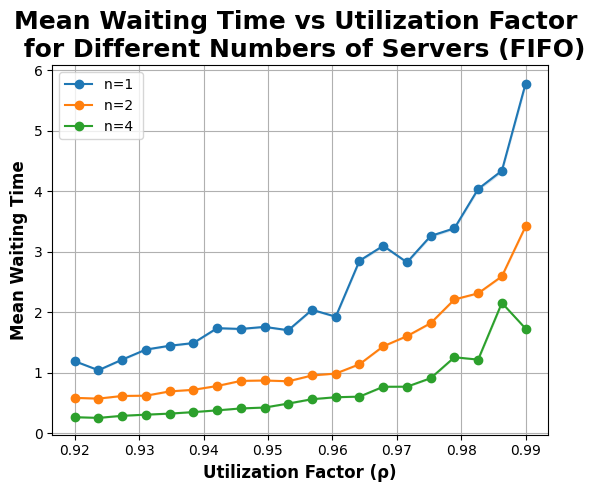

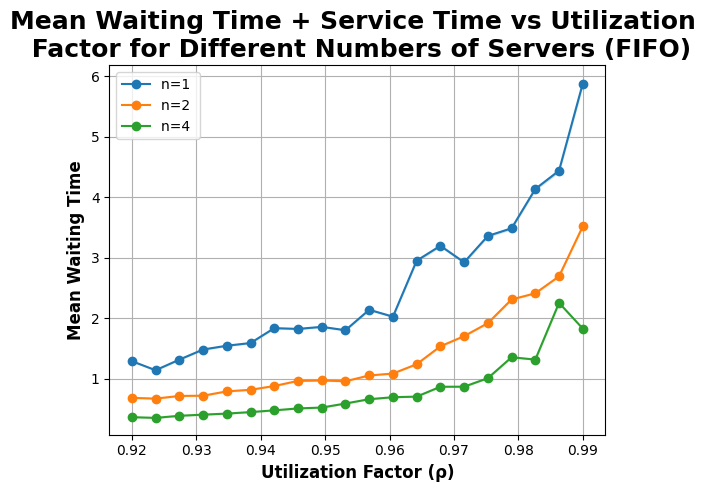

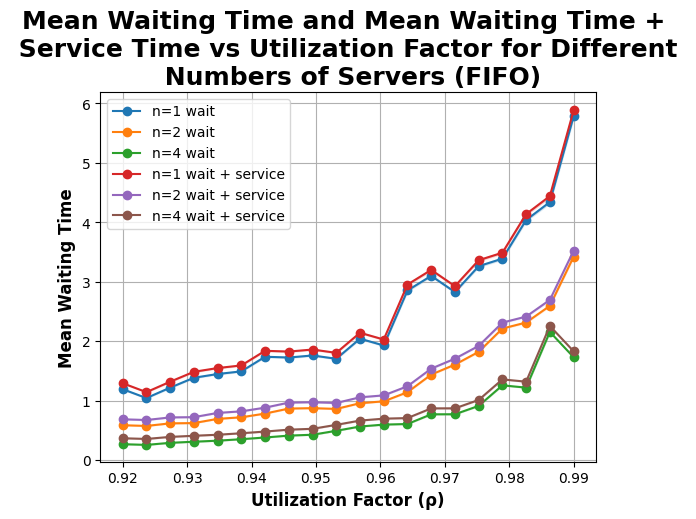

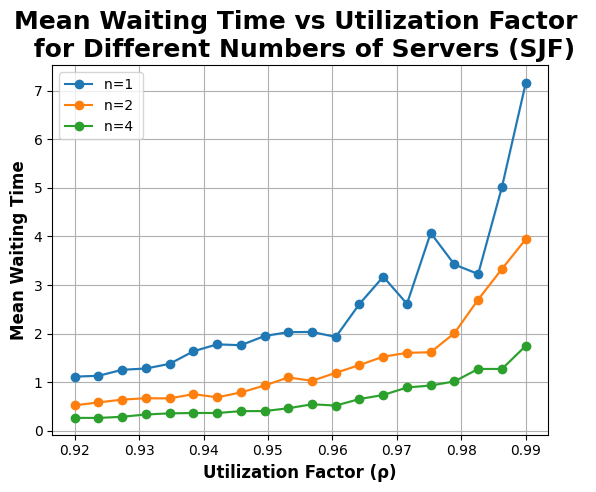

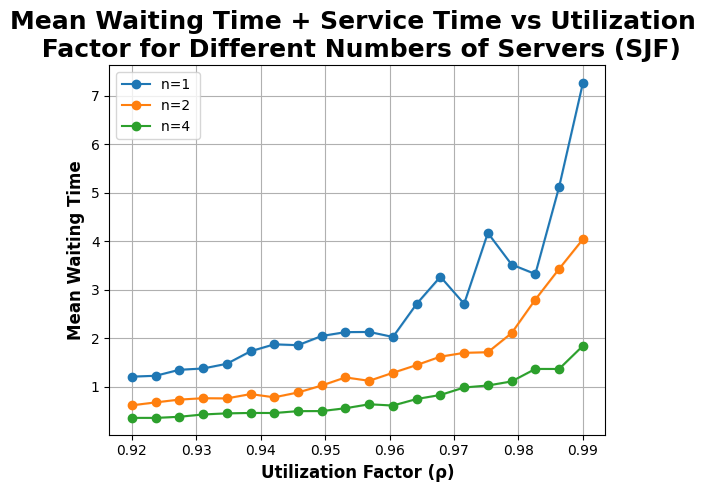

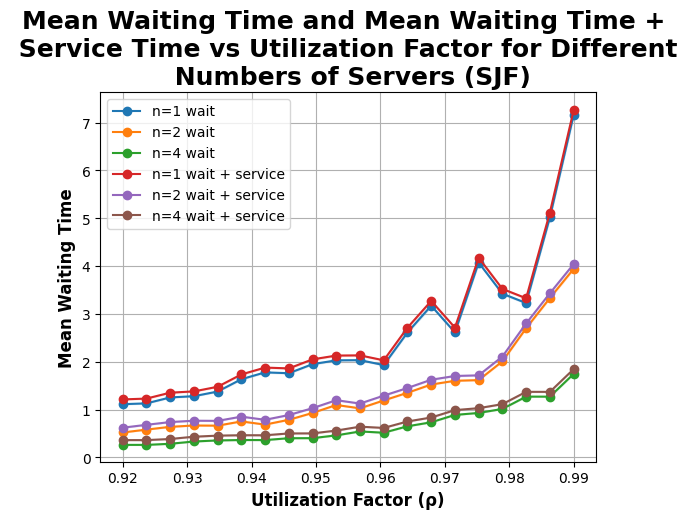

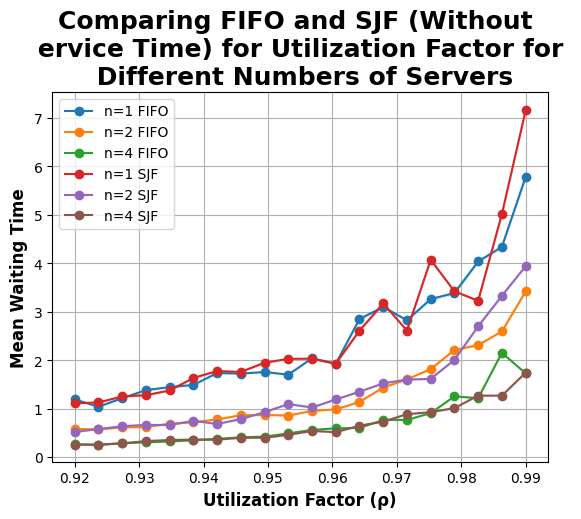

In [27]:
def plotting(results, num_servers, title, results2=None, num_servers2=None, string1="", string2=""):
    plot_data = {}
    for n in num_servers:
        plot_data[n] = []
    for num_server, rho, mean_wait, ci_lower, ci_upper in results:
        plot_data[num_server].append((rho, mean_wait, ci_lower, ci_upper))

    if (results2 != None):
        plot_data2 = {}
        for n in num_servers2:
            plot_data2[n] = []
        for num_server, rho, mean_wait, ci_lower, ci_upper in results2:
            plot_data2[num_server].append((rho, mean_wait, ci_lower, ci_upper))

# for num_servers, rho, mean_wait, ci_lower, ci_upper in results:
#     plt.errorbar(rho, mean_wait, yerr=[[mean_wait - ci_lower], [ci_upper - mean_wait]], fmt='o', label=f'n={num_servers}')

# Plotting the results
    color = 0

    fig, ax = plt.subplots()
    
    # plt.figure(figsize=(10, 6))
    for num_server in num_servers:
        rhos, mean_waits, ci_lowers, ci_uppers = zip(*plot_data[num_server])

        # Creates upper and lower boundaries of condifence interval
        lower_error = tuple(map(operator.sub, mean_waits, ci_lowers))
        upper_error = tuple(map(operator.sub, ci_uppers, mean_waits))


        # OLD CODE FOR ERROR BARS
        # plt.plot(rhos, mean_waits, 'o-', label=f'n={num_server} {string1}', color=list(mcolors.TABLEAU_COLORS)[color])
        # plt.errorbar(rhos, mean_waits, yerr=[lower_error, upper_error], fmt='', label=f'n={num_server} {string1}', color=list(mcolors.TABLEAU_COLORS)[color], capsize = 5)
        # plt.scatter(rhos, mean_waits, marker='o')

        ax.plot(rhos, mean_waits, 'o-', label=f'n={num_server} {string1}', color=list(mcolors.TABLEAU_COLORS)[color])
        ax.fill_between(rhos, [mean_wait - lower for mean_wait, lower in zip(mean_waits, lower_error)], 
                             [mean_wait + upper for mean_wait, upper in zip(mean_waits, upper_error)], 
                             color=list(mcolors.TABLEAU_COLORS)[color], alpha=0.15)
        color += 1

    if (results2 != None):
        for num_server in num_servers2:
            rhos, mean_waits, ci_lowers, ci_uppers = zip(*plot_data2[num_server])

            # Creates upper and lower boundaries of condifence interval
            lower_error = tuple(map(operator.sub, mean_waits, ci_lowers))
            upper_error = tuple(map(operator.sub, ci_uppers, mean_waits))

            # OLD CODE FOR ERROR BARS
            # plt.plot(rhos, mean_waits, 'o-', label=f'n={num_server} {string2}', color=list(mcolors.TABLEAU_COLORS)[color])
            # plt.errorbar(rhos, mean_waits, yerr=[lower_error, upper_error], fmt='', label=f'n={num_server} {string2}', color=list(mcolors.TABLEAU_COLORS)[color], capsize = 5)
            # plt.scatter(rhos, mean_wƒforaits, marker='o')

            ax.plot(rhos, mean_waits, 'o-', label=f'n={num_server} {string2}', color=list(mcolors.TABLEAU_COLORS)[color])
            ax.fill_between(rhos, [mean_wait - lower for mean_wait, lower in zip(mean_waits, lower_error)], 
                             [mean_wait + upper for mean_wait, upper in zip(mean_waits, upper_error)], 
                             color=list(mcolors.TABLEAU_COLORS)[color], alpha=0.15)
            color += 1


    plt.xlabel('Utilization Factor (ρ)', fontsize=12, fontweight='bold')
    plt.ylabel('Mean Waiting Time', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=18, fontweight='bold')
    plt.legend()
    plt.grid(True)
    plt.show()

plotting(results_1, NUM_SERVERS_1, "Mean Waiting Time vs Utilization Factor \n for Different Numbers of Servers (FIFO)")
# plotting(results_2, NUM_SERVERS_2, "Mean Waiting Time vs Utilization Factor for Different Numbers of Servers (SJF)")

plotting(results_included_1, NUM_SERVERS_1, "Mean Waiting Time + Service Time vs Utilization \n Factor for Different Numbers of Servers (FIFO)")
# If you want to plot FIFOor SJF with mean waiting time + service time, uncomment the following line
plotting(results_1, NUM_SERVERS_1, "Mean Waiting Time and Mean Waiting Time + \n Service Time vs Utilization Factor for Different \n Numbers of Servers (FIFO)", results_included_1, NUM_SERVERS_1, "wait", "wait + service")
print()




plotting(results_2, NUM_SERVERS_2, "Mean Waiting Time vs Utilization Factor \n for Different Numbers of Servers (SJF)")
# plotting(results_2, NUM_SERVERS_2, "Mean Waiting Time vs Utilization Factor for Different Numbers of Servers (SJF)")

plotting(results_included_2, NUM_SERVERS_2, "Mean Waiting Time + Service Time vs Utilization \n Factor for Different Numbers of Servers (SJF)")
# If you want to plot FIFOor SJF with mean waiting time + service time, uncomment the following line
plotting(results_2, NUM_SERVERS_2, "Mean Waiting Time and Mean Waiting Time + \n Service Time vs Utilization Factor for Different \n Numbers of Servers (SJF)", results_included_2, NUM_SERVERS_2, "wait", "wait + service")


plotting(results_1, NUM_SERVERS_1, "Comparing FIFO and SJF (Without \n ervice Time) for Utilization Factor for \n Different Numbers of Servers", results_2, NUM_SERVERS_2, "FIFO", "SJF")
